# Variational Autoencoder (VAE) for Brain MRI Analysis

## 🧠 Building a VAE with the OASIS Dataset

This notebook demonstrates how to build a **Variational Autoencoder (VAE)** to analyse brain MR images from the preprocessed OASIS dataset. We'll:

1. **Explore the OASIS brain MRI dataset** - understand what we're working with
2. **Build and train a VAE model** - learn meaningful brain representations
3. **Visualise the learned manifold** - see how the VAE organises brain anatomy
4. **Generate new brain images** - sample from the learned distribution

### What is a VAE?
A **Variational Autoencoder** learns a probabilistic mapping between high-dimensional data (brain images) and a lower-dimensional latent space. Unlike regular autoencoders, VAEs learn smooth, continuous representations that allow for meaningful interpolation and generation.


### About the OASIS Dataset
The **Open Access Series of Imaging Studies (OASIS)** is a collection of neuroimaging datasets made available to the scientific community. Our preprocessed version contains:
- **Brain MRI slices** from multiple subjects
- **Consistent preprocessing** (skull-stripped, normalised)
- **PNG format** for easy loading and processing

## 1. Import Required Libraries

Let's start by importing all the necessary libraries for building our VAE and visualising the results.

In [32]:
# Core libraries for deep learning and VAE
# Implementation follows PyTorch VAE tutorials: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# For data handling and visualisation
import os
from pathlib import Path
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import umap
from sklearn.decomposition import PCA

# Set up plotting style
plt.style.use('default')
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device for training - prioritise MPS for Apple Silicon Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device} (Apple Silicon GPU acceleration)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device} (NVIDIA GPU: {torch.cuda.get_device_name(0)})")
else:
    device = torch.device("cpu")
    print(f"Using device: {device} (CPU only)")

# Additional MPS optimizations for Apple Silicon
if device.type == "mps":
    print("🍎 Apple Silicon optimisations enabled!")
    # Set memory management for MPS
    torch.mps.empty_cache()  # Clear MPS cache

PyTorch version: 2.3.0
MPS available: True
CUDA available: False
Using device: mps (Apple Silicon GPU acceleration)
🍎 Apple Silicon optimisations enabled!


## 2. Load and Explore the OASIS Dataset

Let's explore our brain MRI dataset and understand its structure. The OASIS dataset contains preprocessed brain MRI slices that are perfect for training a VAE.

In [33]:
# Dataset paths - adjust based on your environment
# For local development
DATA_PATH = Path("./keras_png_slices_data")

# For Rangpur cluster (uncomment when running on cluster)
# DATA_PATH = Path("/home/groups/comp3710/keras_png_slices_data")

print(f"📁 Dataset path: {DATA_PATH}")
print(f"📁 Path exists: {DATA_PATH.exists()}")

# Explore dataset structure
if DATA_PATH.exists():
    subdirs = [d.name for d in DATA_PATH.iterdir() if d.is_dir()]
    print(f"📂 Available subdirectories:")
    for subdir in subdirs:
        if DATA_PATH / subdir:
            file_count = len(list((DATA_PATH / subdir).glob("*.png")))
            print(f"   {subdir}: {file_count} files")

# Define our main data directories
train_dir = DATA_PATH / "keras_png_slices_train"
val_dir = DATA_PATH / "keras_png_slices_validate" 
test_dir = DATA_PATH / "keras_png_slices_test"

print(f"\n🎯 We'll focus on the brain images (not segmentation masks)")
print(f"📊 Training images: {len(list(train_dir.glob('*.png'))) if train_dir.exists() else 0}")
print(f"📊 Validation images: {len(list(val_dir.glob('*.png'))) if val_dir.exists() else 0}")
print(f"📊 Test images: {len(list(test_dir.glob('*.png'))) if test_dir.exists() else 0}")

📁 Dataset path: keras_png_slices_data
📁 Path exists: True
📂 Available subdirectories:
   keras_png_slices_seg_test: 544 files
   keras_png_slices_test: 544 files
   keras_png_slices_train: 9664 files
   keras_png_slices_seg_train: 9664 files
   keras_png_slices_validate: 1120 files
   keras_png_slices_seg_validate: 1120 files

🎯 We'll focus on the brain images (not segmentation masks)
📊 Training images: 9664
📊 Validation images: 1120
📊 Test images: 544


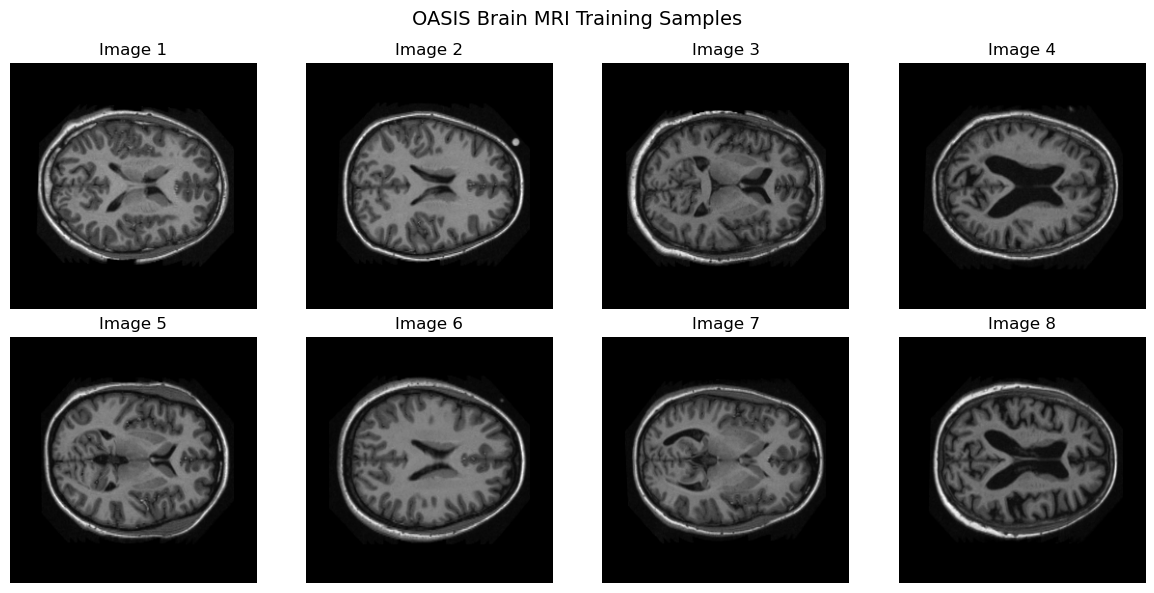


📋 Image Properties:
   📐 Shape: (256, 256)
   📊 Data type: uint8
   📈 Value range: [0, 255]
   📏 Image files found: 8


In [34]:
# Let's look at some sample brain images to understand our data
def show_sample_images(data_dir, num_samples=8, title="Sample Brain MRI Images"):
    """Display a grid of sample brain MRI images"""
    if not data_dir.exists():
        print(f"❌ Directory not found: {data_dir}")
        return
    
    image_files = list(data_dir.glob("*.png"))[:num_samples]
    
    if len(image_files) == 0:
        print(f"❌ No PNG files found in {data_dir}")
        return
    
    # Create subplot grid
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    axes = axes.flatten()
    
    for i, img_path in enumerate(image_files):
        # Load and display image
        img = Image.open(img_path).convert('L')  # Convert to greyscale
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(image_files), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Show image properties
    sample_img = np.array(Image.open(image_files[0]).convert('L'))
    print(f"\n📋 Image Properties:")
    print(f"   📐 Shape: {sample_img.shape}")
    print(f"   📊 Data type: {sample_img.dtype}")
    print(f"   📈 Value range: [{sample_img.min()}, {sample_img.max()}]")
    print(f"   📏 Image files found: {len(image_files)}")

# Display sample images
show_sample_images(train_dir, num_samples=8, title="OASIS Brain MRI Training Samples")

## 3. Data Preprocessing and Preparation

Now let's prepare our data for training the VAE. We'll resize images to 64x64 for computational efficiency while preserving the important brain features.

In [35]:
# Configuration parameters
# Architecture based on PyTorch VAE tutorials: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
IMG_HEIGHT = 64  # Resize height for computational efficiency
IMG_WIDTH = 64   # Resize width
IMG_CHANNELS = 1  # Greyscale
LATENT_DIM = 20   # Dimension of the latent space
BATCH_SIZE = 32   # Training batch size
MAX_IMAGES = 5000  # Limit for quick training (remove for full dataset)

# MPS-specific optimisations for Apple Silicon
if device.type == "mps":
    print("🍎 Applying Apple Silicon optimisations:")
    print(f"   📦 Batch size: {BATCH_SIZE} (optimised for MPS)")
    print(f"   🧠 Mixed precision: Not recommended for MPS yet")
    print(f"   💾 Memory management: Automatic cache clearing enabled")

def load_and_preprocess_images(data_dir, max_images=None):
    """Load and preprocess brain MRI images for PyTorch"""
    if not data_dir.exists():
        print(f"❌ Directory not found: {data_dir}")
        return None
    
    image_files = list(data_dir.glob("*.png"))
    
    # Limit number of images for faster training (optional)
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"📊 Loading {len(image_files)} images from {data_dir.name}...")
    
    # Define transforms for preprocessing
    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),  # Converts PIL Image to tensor and scales to [0,1]
    ])
    
    images = []
    for img_path in image_files:
        # Load image
        img = Image.open(img_path).convert('L')  # Convert to greyscale
        
        # Apply transforms
        img_tensor = transform(img)  # Shape: (1, H, W)
        
        images.append(img_tensor)
    
    # Stack into a single tensor
    images = torch.stack(images)  # Shape: (N, 1, H, W)
    
    return images

# Load training data
print("🔄 Loading and preprocessing training data...")
X_train = load_and_preprocess_images(train_dir, max_images=MAX_IMAGES)

if X_train is not None:
    print(f"✅ Training data loaded successfully!")
    print(f"   📐 Shape: {X_train.shape}")
    print(f"   📊 Data type: {X_train.dtype}")
    print(f"   📈 Value range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    
    # Split into train and validation sets
    train_size = int(0.8 * len(X_train))
    val_size = len(X_train) - train_size
    X_train_split, X_val = torch.split(X_train, [train_size, val_size])
    
    print(f"   🔀 Training set: {X_train_split.shape[0]} images")
    print(f"   🔀 Validation set: {X_val.shape[0]} images")
    
    # Create PyTorch DataLoaders
    train_dataset = TensorDataset(X_train_split)
    val_dataset = TensorDataset(X_val)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"   📦 Created DataLoaders with batch size: {BATCH_SIZE}")
    
    # Update variable names for compatibility
    X_train = X_train_split
else:
    print("❌ Failed to load training data")

🍎 Applying Apple Silicon optimisations:
   📦 Batch size: 32 (optimised for MPS)
   🧠 Mixed precision: Not recommended for MPS yet
   💾 Memory management: Automatic cache clearing enabled
🔄 Loading and preprocessing training data...
📊 Loading 5000 images from keras_png_slices_train...
✅ Training data loaded successfully!
   📐 Shape: torch.Size([5000, 1, 64, 64])
   📊 Data type: torch.float32
   📈 Value range: [0.000, 0.957]
   🔀 Training set: 4000 images
   🔀 Validation set: 1000 images
   📦 Created DataLoaders with batch size: 32
✅ Training data loaded successfully!
   📐 Shape: torch.Size([5000, 1, 64, 64])
   📊 Data type: torch.float32
   📈 Value range: [0.000, 0.957]
   🔀 Training set: 4000 images
   🔀 Validation set: 1000 images
   📦 Created DataLoaders with batch size: 32


## 4. Build the VAE Encoder Network

The encoder network takes brain images and maps them to latent space parameters (mean and log variance). This is the "recognition" network that learns to compress brain anatomy into meaningful representations.

In [36]:
class Encoder(nn.Module):
    """
    Encoder network that maps brain images to latent parameters
    
    Architecture inspired by:
    - Kingma & Welling (2013): Auto-Encoding Variational Bayes
    - PyTorch VAE tutorials: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    
    Args:
        input_channels: Number of input channels (1 for greyscale)
        latent_dim: Dimension of latent space
    """
    
    def __init__(self, input_channels=1, latent_dim=20):
        super(Encoder, self).__init__()
        
        # Convolutional layers - progressively reduce spatial dimensions
        self.conv_layers = nn.Sequential(
            # Input: (batch, 1, 64, 64)
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),  # -> (batch, 32, 32, 32)
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (batch, 64, 16, 16)
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> (batch, 128, 8, 8)
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # -> (batch, 256, 4, 4)
            nn.ReLU(inplace=True),
        )
        
        # Calculate the size after convolutions
        self.flatten_size = 256 * 4 * 4  # 256 channels * 4 * 4 spatial dimensions
        
        # Dense layers
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(inplace=True),
        )
        
        # Latent space parameters
        self.fc_mean = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
    
    def forward(self, x):
        # Convolutional layers
        x = self.conv_layers(x)
        
        # Flatten
        x = x.view(x.size(0), -1)  # (batch, flatten_size)
        
        # Dense layers
        x = self.fc(x)
        
        # Latent parameters
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        
        return z_mean, z_log_var

# Build the encoder
encoder = Encoder(input_channels=IMG_CHANNELS, latent_dim=LATENT_DIM).to(device)

print("🔧 Encoder Architecture:")
print(encoder)

# Test encoder architecture
if X_train is not None:
    # Test with a sample image
    sample_image = X_train[0:1].to(device)  # First image with batch dimension
    z_mean, z_log_var = encoder(sample_image)
    print(f"\n✅ Encoder test successful!")
    print(f"   📐 Input shape: {sample_image.shape}")
    print(f"   📐 Z mean shape: {z_mean.shape}")
    print(f"   📐 Z log var shape: {z_log_var.shape}")

🔧 Encoder Architecture:
Encoder(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc_mean): Linear(in_features=256, out_features=20, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=20, bias=True)
)

✅ Encoder test successful!
   📐 Input shape: torch.Size([1, 1, 64, 64])
   📐 Z mean shape: torch.Size([1, 20])
   📐 Z log var shape: torch.Size([1, 20])

✅ Encoder test successful!
   📐 Input shape: torch.Size([1, 1, 64, 64])
   📐 Z mean shape: torch.Size([1, 20])
   📐

## 5. Build the VAE Decoder Network

The decoder network takes latent representations and reconstructs brain images. This is the "generative" network that learns to create realistic brain MRI images from compressed representations.

In [37]:
class Decoder(nn.Module):
    """
    Decoder network that reconstructs brain images from latent codes
    
    Architecture based on:
    - Transpose convolution approach from PyTorch VAE tutorials
    - https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    
    Args:
        latent_dim: Dimension of latent space
        output_channels: Number of output channels (1 for greyscale)
    """
    
    def __init__(self, latent_dim=20, output_channels=1):
        super(Decoder, self).__init__()
        
        # Dense layer to prepare for upsampling
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 256),
            nn.ReLU(inplace=True)
        )
        
        # Transpose convolutions - progressively increase spatial dimensions
        self.deconv_layers = nn.Sequential(
            # Input: (batch, 256, 4, 4)
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (batch, 256, 8, 8)
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (batch, 128, 16, 16)
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (batch, 64, 32, 32)
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (batch, 32, 64, 64)
            nn.ReLU(inplace=True),
            
            # Final layer - output reconstructed image
            nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=1, padding=1),         # -> (batch, 1, 64, 64)
            nn.Sigmoid()  # Output in range [0, 1]
        )
    
    def forward(self, z):
        # Dense layer
        x = self.fc(z)  # (batch, 4*4*256)
        
        # Reshape for convolutions
        x = x.view(x.size(0), 256, 4, 4)  # (batch, 256, 4, 4)
        
        # Transpose convolutions
        x = self.deconv_layers(x)
        
        return x

# Build the decoder
decoder = Decoder(latent_dim=LATENT_DIM, output_channels=IMG_CHANNELS).to(device)

print("🔧 Decoder Architecture:")
print(decoder)

# Test decoder
if X_train is not None:
    # Create a random latent code
    sample_z = torch.randn(1, LATENT_DIM).to(device)
    reconstructed = decoder(sample_z)
    print(f"\n✅ Decoder test successful!")
    print(f"   📐 Input latent shape: {sample_z.shape}")
    print(f"   📐 Output image shape: {reconstructed.shape}")
    print(f"   📈 Output range: [{reconstructed.min():.3f}, {reconstructed.max():.3f}]")

🔧 Decoder Architecture:
Decoder(
  (fc): Sequential(
    (0): Linear(in_features=20, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
  )
  (deconv_layers): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
  )
)

✅ Decoder test successful!
   📐 Input latent shape: torch.Size([1, 20])
   📐 Output image shape: torch.Size([1, 1, 64, 64])
   📈 Output range: [0.549, 0.593]
   📈 Outpu

## 6. Define the VAE Loss Function

The VAE loss combines two components:
1. **Reconstruction Loss**: How well we can recreate the original image
2. **KL Divergence**: Regularization term that keeps the latent space well-structured

In [38]:
class VAE(nn.Module):
    """
    Variational Autoencoder combining encoder and decoder
    
    Implementation based on:
    - Kingma & Welling (2013): Auto-Encoding Variational Bayes
    - PyTorch VAE tutorials: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def reparameterise(self, z_mean, z_log_var):
        """Reparameterisation trick: sample from latent space"""
        batch_size = z_mean.size(0)
        latent_dim = z_mean.size(1)
        epsilon = torch.randn(batch_size, latent_dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon
    
    def forward(self, x):
        """Forward pass through the VAE"""
        # Encode
        z_mean, z_log_var = self.encoder(x)
        
        # Sample from latent space
        z = self.reparameterise(z_mean, z_log_var)
        
        # Decode
        reconstruction = self.decoder(z)
        
        return reconstruction, z_mean, z_log_var
    
    def loss_function(self, reconstruction, x, z_mean, z_log_var):
        """
        Compute VAE loss = Reconstruction Loss + KL Divergence
        """
        # Reconstruction loss (Binary Cross Entropy)
        reconstruction_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
        
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
        
        return reconstruction_loss + kl_loss, reconstruction_loss, kl_loss

# Create the VAE model
vae = VAE(encoder, decoder).to(device)

# Create optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

print("✅ VAE model created successfully!")
print(f"   🧠 Encoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")
print(f"   🎨 Decoder parameters: {sum(p.numel() for p in decoder.parameters()):,}")
print(f"   🔗 Total VAE parameters: {sum(p.numel() for p in vae.parameters()):,}")

# Test the VAE model
if X_train is not None:
    # Test with a sample batch
    sample_batch = X_train[:2].to(device)  # Use first 2 images
    reconstruction, z_mean, z_log_var = vae(sample_batch)
    total_loss, recon_loss, kl_loss = vae.loss_function(reconstruction, sample_batch, z_mean, z_log_var)
    print(f"\n✅ VAE test successful!")
    print(f"   📐 Input shape: {sample_batch.shape}")
    print(f"   📐 Reconstruction shape: {reconstruction.shape}")
    print(f"   📊 Total loss: {total_loss.item():.2f}")
    print(f"   📊 Reconstruction loss: {recon_loss.item():.2f}")
    print(f"   📊 KL loss: {kl_loss.item():.2f}")

✅ VAE model created successfully!
   🧠 Encoder parameters: 1,446,952
   🎨 Decoder parameters: 1,063,681
   🔗 Total VAE parameters: 2,510,633

✅ VAE test successful!
   📐 Input shape: torch.Size([2, 1, 64, 64])
   📐 Reconstruction shape: torch.Size([2, 1, 64, 64])
   📊 Total loss: 6594.43
   📊 Reconstruction loss: 6594.39
   📊 KL loss: 0.04

✅ VAE test successful!
   📐 Input shape: torch.Size([2, 1, 64, 64])
   📐 Reconstruction shape: torch.Size([2, 1, 64, 64])
   📊 Total loss: 6594.43
   📊 Reconstruction loss: 6594.39
   📊 KL loss: 0.04


## 7. Compile and Train the VAE Model

Now let's train our VAE on the brain MRI data. We'll monitor the training progress and save the best model.

🍎 Starting VAE training on MPS...
   📊 Training samples: 4000
   📊 Validation samples: 1000
   🎯 Epochs: 50
   📦 Batch size: 32
   🍎 Apple Silicon GPU acceleration active
   💾 Advanced MPS memory management enabled
🍎 Starting VAE training on MPS...
🚀 Apple Silicon optimisations active:
   💾 Enhanced memory management enabled
   ⚡ Non-blocking data transfer active
   🧠 MPS cache clearing every 5 batches
🍎 Epoch [1/50], Train Loss: 1913.8384, Val Loss: 1203.6014
🍎 Epoch [1/50], Train Loss: 1913.8384, Val Loss: 1203.6014
🍎 Epoch [6/50], Train Loss: 1094.3401, Val Loss: 1092.5089
🍎 Epoch [6/50], Train Loss: 1094.3401, Val Loss: 1092.5089
🍎 Epoch [11/50], Train Loss: 1084.0589, Val Loss: 1086.3231
🍎 Epoch [11/50], Train Loss: 1084.0589, Val Loss: 1086.3231
🍎 Epoch [16/50], Train Loss: 1074.0934, Val Loss: 1072.8844
🍎 Epoch [16/50], Train Loss: 1074.0934, Val Loss: 1072.8844
🍎 Epoch [21/50], Train Loss: 1070.3227, Val Loss: 1069.6558
🍎 Epoch [21/50], Train Loss: 1070.3227, Val Loss: 1069.655

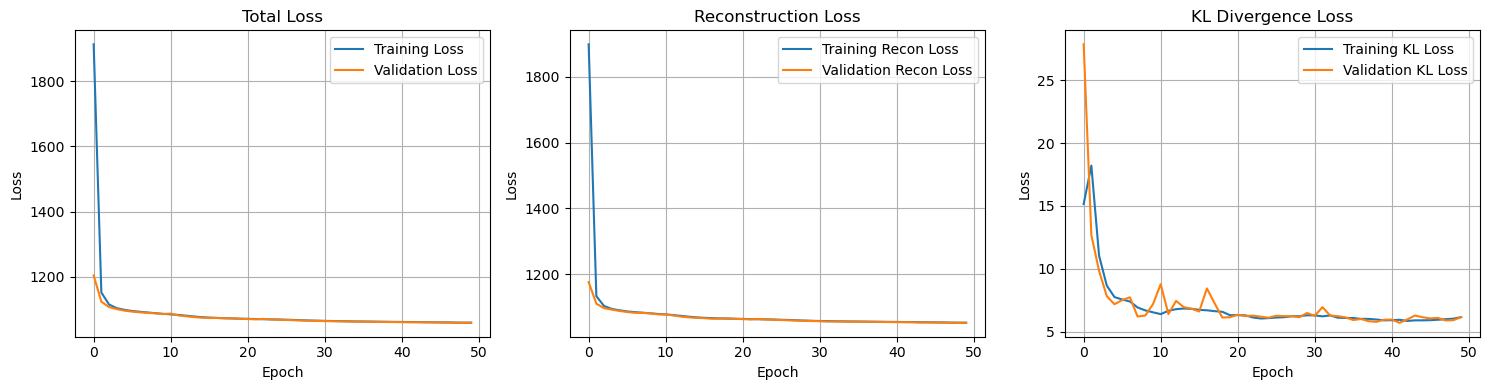

In [39]:
# Training configuration
EPOCHS = 50  # Adjust based on your computational resources

# Training function with Apple Silicon MPS optimisations
def train_vae(vae, train_loader, val_loader, optimizer, epochs, device):
    """
    Train the VAE with PyTorch and Apple Silicon MPS optimisations.
    
    MPS optimisations include:
    - Enhanced memory management with frequent cache clearing
    - Non-blocking data transfer for improved throughput
    - Apple Silicon-specific progress indicators
    """
    vae.train()
    
    # Track training history
    train_losses = []
    train_recon_losses = []
    train_kl_losses = []
    val_losses = []
    val_recon_losses = []
    val_kl_losses = []
    
    # Display device-specific startup message
    device_emoji = "🍎" if device.type == "mps" else "🖥️" if device.type == "cuda" else "💻"
    print(f"{device_emoji} Starting VAE training on {device.type.upper()}...")
    
    # MPS-specific optimisation messages
    if device.type == "mps":
        print("🚀 Apple Silicon optimisations active:")
        print("   💾 Enhanced memory management enabled")
        print("   ⚡ Non-blocking data transfer active")
        print("   🧠 MPS cache clearing every 5 batches")
    
    for epoch in range(epochs):
        # Training phase
        epoch_train_loss = 0
        epoch_train_recon = 0
        epoch_train_kl = 0
        
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(device, non_blocking=True)  # Non-blocking transfer for MPS efficiency
            
            optimizer.zero_grad()
            
            # Forward pass
            reconstruction, z_mean, z_log_var = vae(data)
            
            # Compute loss
            total_loss, recon_loss, kl_loss = vae.loss_function(reconstruction, data, z_mean, z_log_var)
            
            # Backward pass
            total_loss.backward()
            optimizer.step()
            
            # Track losses
            epoch_train_loss += total_loss.item()
            epoch_train_recon += recon_loss.item()
            epoch_train_kl += kl_loss.item()
            
            # Enhanced MPS memory management for Apple Silicon - more frequent clearing
            if device.type == "mps" and batch_idx % 5 == 0:
                torch.mps.empty_cache()  # Clear MPS cache every 5 batches for optimal performance
        
        # Validation phase
        vae.eval()
        epoch_val_loss = 0
        epoch_val_recon = 0
        epoch_val_kl = 0
        
        with torch.no_grad():
            for data, in val_loader:
                data = data.to(device, non_blocking=True)  # Non-blocking for MPS efficiency
                reconstruction, z_mean, z_log_var = vae(data)
                total_loss, recon_loss, kl_loss = vae.loss_function(reconstruction, data, z_mean, z_log_var)
                
                epoch_val_loss += total_loss.item()
                epoch_val_recon += recon_loss.item()
                epoch_val_kl += kl_loss.item()
        
        # Average losses
        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        avg_train_recon = epoch_train_recon / len(train_loader.dataset)
        avg_train_kl = epoch_train_kl / len(train_loader.dataset)
        
        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        avg_val_recon = epoch_val_recon / len(val_loader.dataset)
        avg_val_kl = epoch_val_kl / len(val_loader.dataset)
        
        # Store losses
        train_losses.append(avg_train_loss)
        train_recon_losses.append(avg_train_recon)
        train_kl_losses.append(avg_train_kl)
        val_losses.append(avg_val_loss)
        val_recon_losses.append(avg_val_recon)
        val_kl_losses.append(avg_val_kl)
        
        # Print progress with device-specific emoji
        if epoch % 5 == 0 or epoch == epochs - 1:
            device_emoji = "🍎" if device.type == "mps" else "🖥️" if device.type == "cuda" else "💻"
            print(f'{device_emoji} Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # End-of-epoch memory management for optimal Apple Silicon performance
        if device.type == "mps":
            torch.mps.empty_cache()  # Essential MPS memory cleanup
        elif device.type == "cuda":
            torch.cuda.empty_cache()
        
        vae.train()
    
    # Final completion message with device-specific celebration
    if device.type == "mps":
        print("✅ Training completed successfully on Apple Silicon! 🚀")
        print("🍎 MPS acceleration utilised throughout training")
    else:
        print(f"✅ Training completed successfully on {device.type.upper()}!")
    
    return {
        'train_loss': train_losses,
        'train_recon_loss': train_recon_losses,
        'train_kl_loss': train_kl_losses,
        'val_loss': val_losses,
        'val_recon_loss': val_recon_losses,
        'val_kl_loss': val_kl_losses
    }

# Train the VAE with Apple Silicon optimisations (only if we have data loaded)
if X_train is not None and X_val is not None:
    device_emoji = "🍎" if device.type == "mps" else "🖥️" if device.type == "cuda" else "💻"
    print(f"{device_emoji} Starting VAE training on {device.type.upper()}...")
    print(f"   📊 Training samples: {X_train.shape[0]}")
    print(f"   📊 Validation samples: {X_val.shape[0]}")
    print(f"   🎯 Epochs: {EPOCHS}")
    print(f"   📦 Batch size: {BATCH_SIZE}")
    
    if device.type == "mps":
        print(f"   🍎 Apple Silicon GPU acceleration active")
        print(f"   💾 Advanced MPS memory management enabled")
    
    # Start training with MPS optimisations
    history = train_vae(vae, train_loader, val_loader, optimizer, EPOCHS, device)
    
    print("✅ Training completed!")
    
    # Plot training history
    plt.figure(figsize=(15, 4))
    
    # Total loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Reconstruction loss
    plt.subplot(1, 3, 2)
    plt.plot(history['train_recon_loss'], label='Training Recon Loss')
    plt.plot(history['val_recon_loss'], label='Validation Recon Loss')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # KL loss
    plt.subplot(1, 3, 3)
    plt.plot(history['train_kl_loss'], label='Training KL Loss')
    plt.plot(history['val_kl_loss'], label='Validation KL Loss')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Cannot train - no data loaded. Please check your data path.")

## 8. Generate New Images from the Latent Space

Let's test our trained VAE by generating new brain images and comparing reconstructions with original images.

🔍 Testing image reconstruction...


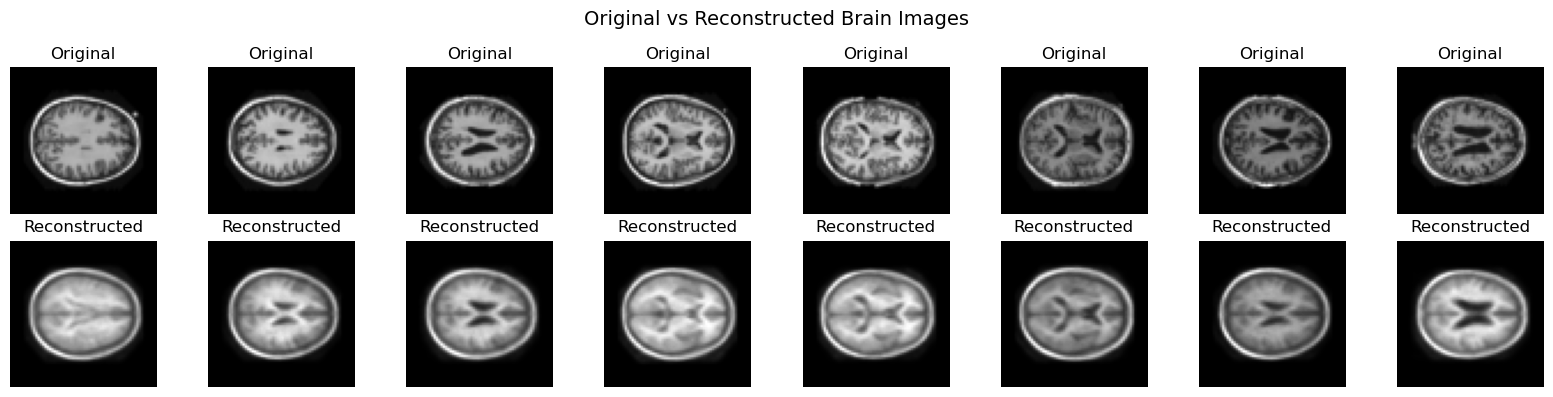


🎨 Generating new brain images...


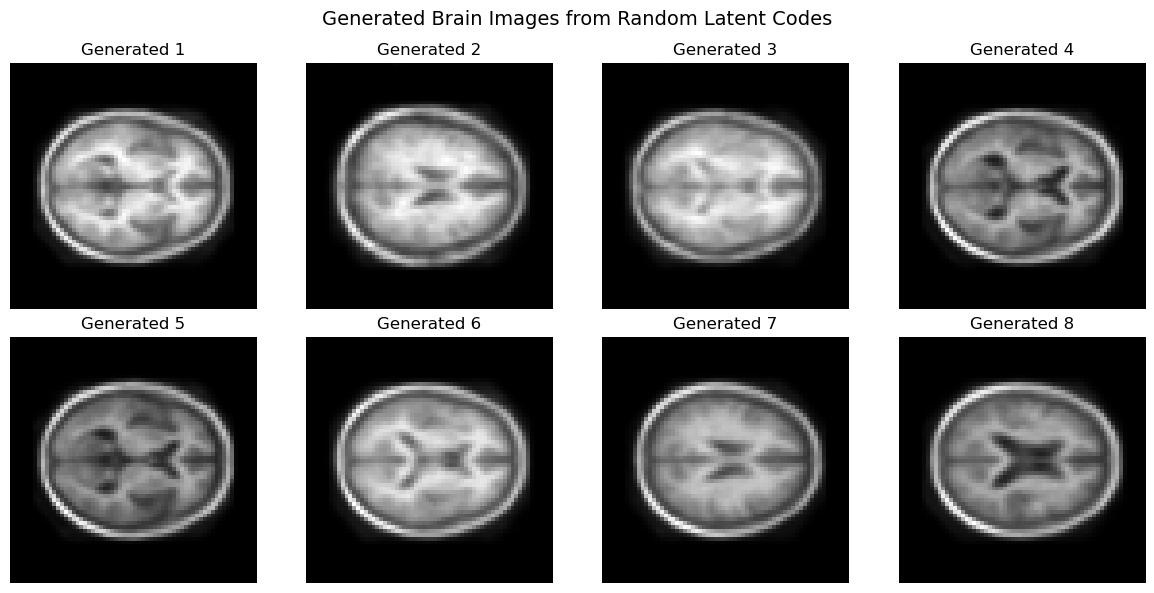

In [40]:
def plot_reconstructions(vae, data, n_samples=8):
    """Plot original images vs reconstructions"""
    vae.eval()
    with torch.no_grad():
        data_sample = data[:n_samples].to(device)
        
        # Get reconstructions
        reconstructions, _, _ = vae(data_sample)
        
        # Convert to CPU and numpy for plotting
        data_sample = data_sample.cpu()
        reconstructions = reconstructions.cpu()
    
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 2, 4))
    
    for i in range(n_samples):
        # Original images
        axes[0, i].imshow(data_sample[i].squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Reconstructed images
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.suptitle('Original vs Reconstructed Brain Images', fontsize=14)
    plt.tight_layout()
    plt.show()

def generate_new_images(decoder, n_samples=8):
    """Generate new brain images by sampling from latent space"""
    decoder.eval()
    with torch.no_grad():
        # Sample random latent codes
        random_latent_vectors = torch.randn(n_samples, LATENT_DIM).to(device)
        
        # Generate images
        generated_images = decoder(random_latent_vectors)
        
        # Convert to CPU for plotting
        generated_images = generated_images.cpu()
    
    # Plot generated images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(n_samples):
        axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Generated {i+1}')
        axes[i].axis('off')
    
    plt.suptitle('Generated Brain Images from Random Latent Codes', fontsize=14)
    plt.tight_layout()
    plt.show()

# Test image generation (only if model is trained)
if X_val is not None:
    print("🔍 Testing image reconstruction...")
    plot_reconstructions(vae, X_val, n_samples=8)
    
    print("\n🎨 Generating new brain images...")
    generate_new_images(decoder, n_samples=8)
else:
    print("❌ Cannot generate images - model not trained yet.")

## 9. Visualize the Latent Space Manifold

Now let's create a 2D visualization of the latent space by sampling a grid of points and seeing how the generated images change smoothly across the manifold.

🗺️ Creating 2D latent space manifold visualisation...


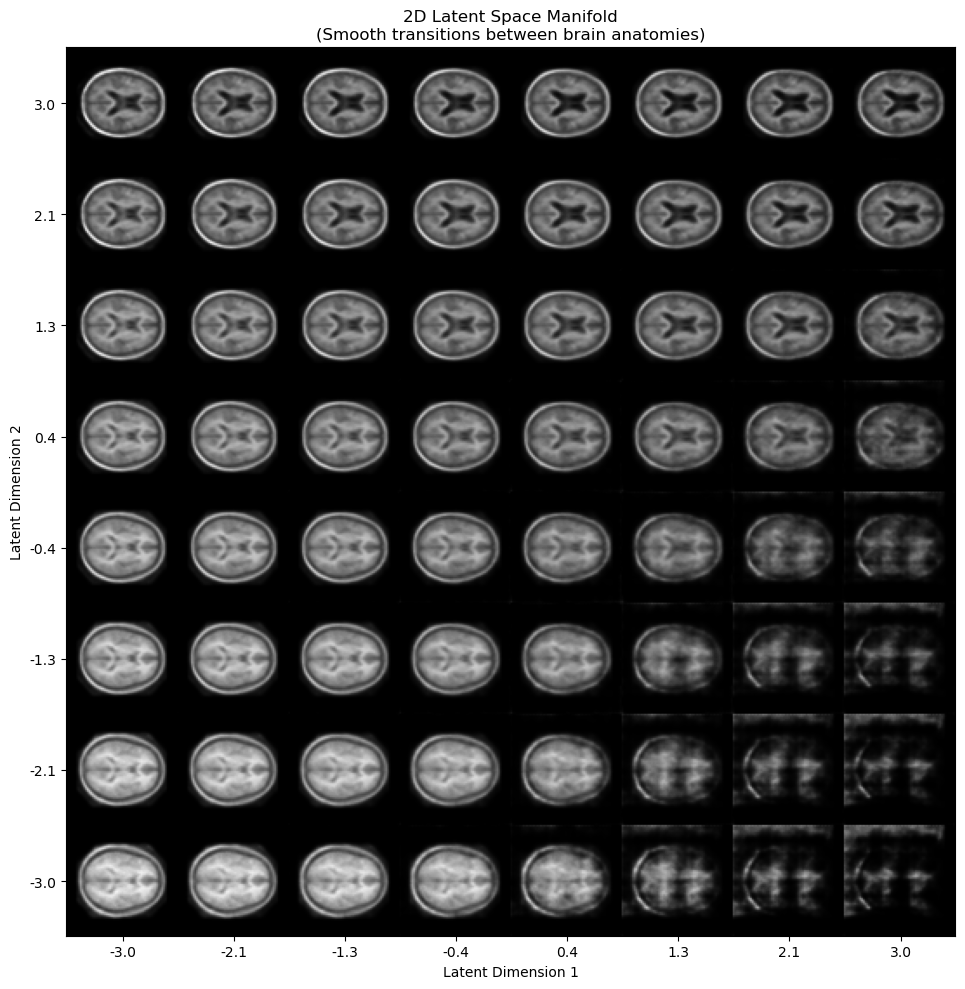


🔄 Creating latent space interpolation...


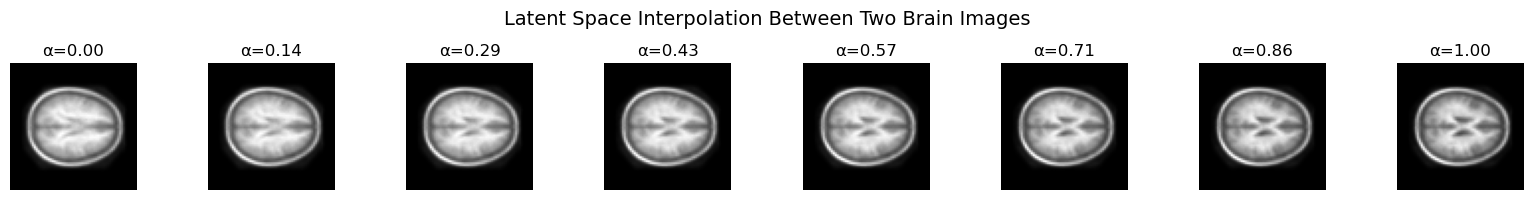

In [41]:
def plot_latent_manifold(decoder, n=10, figsize=12):
    """
    Create a 2D grid sampling of the latent space showing smooth transitions
    This visualisation shows how the first two dimensions of the latent space
    control the generated brain anatomy.
    """
    decoder.eval()
    
    # Create a grid of latent codes
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)
    
    # Create figure
    figure = np.zeros((IMG_HEIGHT * n, IMG_WIDTH * n))
    
    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                # Create latent code (only varying first 2 dimensions)
                z_sample = torch.zeros(1, LATENT_DIM).to(device)
                z_sample[0, 0] = xi  # First latent dimension
                z_sample[0, 1] = yi  # Second latent dimension
                
                # Generate image
                x_decoded = decoder(z_sample)
                digit = x_decoded[0].cpu().squeeze().numpy()
                
                # Place in grid
                figure[i * IMG_HEIGHT: (i + 1) * IMG_HEIGHT,
                       j * IMG_WIDTH: (j + 1) * IMG_WIDTH] = digit
    
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='gray')
    plt.title('2D Latent Space Manifold\n(Smooth transitions between brain anatomies)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    
    # Add grid ticks
    tick_positions = np.arange(0, n * IMG_WIDTH, IMG_WIDTH) + IMG_WIDTH // 2
    tick_labels = [f'{x:.1f}' for x in grid_x]
    plt.xticks(tick_positions, tick_labels)
    plt.yticks(tick_positions, tick_labels[::-1])  # Reverse for proper orientation
    
    plt.tight_layout()
    plt.show()

def plot_latent_interpolation(encoder, decoder, data, n_steps=8):
    """Show interpolation between two real brain images in latent space"""
    if len(data) < 2:
        print("❌ Need at least 2 images for interpolation")
        return
    
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        # Move data to device and encode two images
        data_device = data[:2].to(device)
        z1_mean, z1_log_var = encoder(data_device[0:1])
        z2_mean, z2_log_var = encoder(data_device[1:2])
        
        # Use means for interpolation (ignore variance for simplicity)
        z1 = z1_mean
        z2 = z2_mean
        
        # Create interpolation steps
        alphas = np.linspace(0, 1, n_steps)
        
        fig, axes = plt.subplots(1, n_steps, figsize=(n_steps * 2, 2))
        
        for i, alpha in enumerate(alphas):
            # Interpolate in latent space
            z_interp = (1 - alpha) * z1 + alpha * z2
            
            # Decode to get image
            img_interp = decoder(z_interp)
            
            # Display
            axes[i].imshow(img_interp[0].cpu().squeeze(), cmap='gray')
            axes[i].set_title(f'α={alpha:.2f}')
            axes[i].axis('off')
    
    plt.suptitle('Latent Space Interpolation Between Two Brain Images', fontsize=14)
    plt.tight_layout()
    plt.show()

# Create manifold visualizations (only if model is trained)
if X_val is not None:
    print("🗺️ Creating 2D latent space manifold visualisation...")
    plot_latent_manifold(decoder, n=8, figsize=10)
    
    print("\n🔄 Creating latent space interpolation...")
    plot_latent_interpolation(encoder, decoder, X_val, n_steps=8)
else:
    print("❌ Cannot create visualisations - model not trained yet.")

## 10. Apply Dimensionality Reduction (UMAP) for Visualisation

Finally, let's use UMAP (Uniform Manifold Approximation and Projection) to visualise how the VAE organises different brain images in the latent space. This will show us the structure of the learned manifold.

🎨 Creating UMAP visualisation of latent space...
🔍 Encoding 800 images to latent space...
📐 Latent codes shape: (800, 20)
🗺️ Applying UMAP dimensionality reduction...
📐 Latent codes shape: (800, 20)
🗺️ Applying UMAP dimensionality reduction...


/Users/kunwa/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


📊 Applying PCA for comparison...


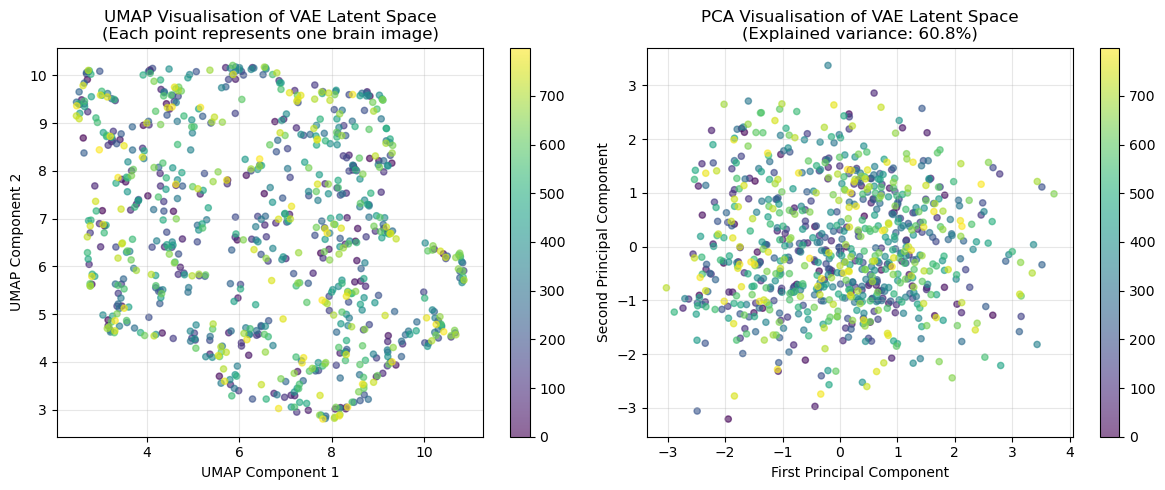


📈 Latent Space Statistics:
   📏 Original dimensions: 20
   📊 Mean latent values: [-0.4924905  -0.15031828 -0.0185939  -0.03995381  0.14132892]... (first 5)
   📊 Std latent values: [0.8132567  0.9659887  0.089406   0.09717018 0.2825939 ]... (first 5)
   🎯 UMAP preserved 800 points
   🎯 PCA explained variance: 60.8%

📊 Analysing latent space dimensions...
🔍 Analysing latent dimensions with 500 samples...


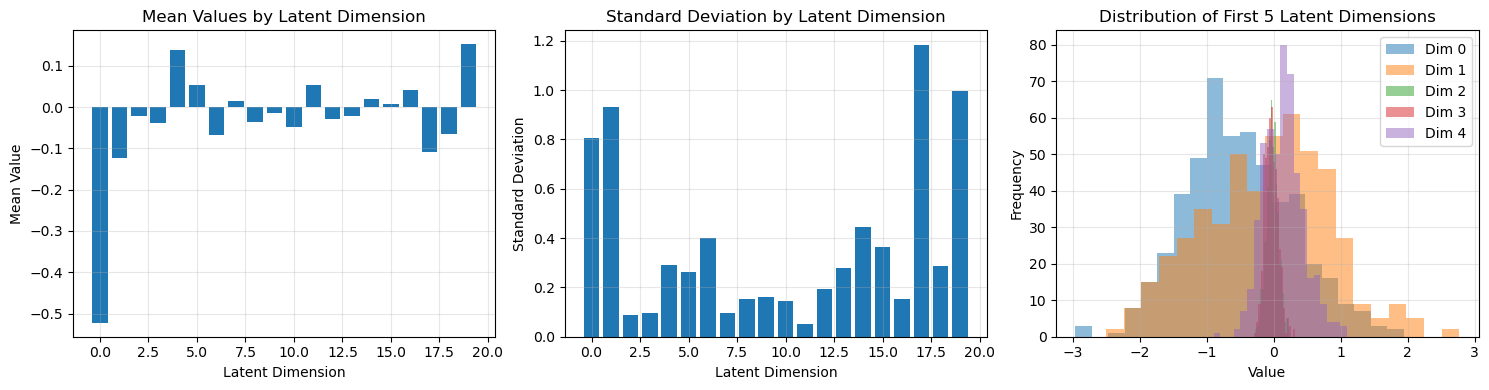

<Figure size 640x480 with 0 Axes>

In [44]:
def visualise_latent_space_umap(encoder, data, n_samples=1000):
    """
    Use UMAP to visualise the latent space structure
    
    Reference: McInnes, L., Healy, J., & Melville, J. (2018). 
    UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction.
    https://arxiv.org/abs/1802.03426
    """
    print(f"🔍 Encoding {min(n_samples, len(data))} images to latent space...")
    
    encoder.eval()
    
    # Select subset of data for visualisation
    sample_data = data[:min(n_samples, len(data))].to(device)
    
    with torch.no_grad():
        # Encode to latent space
        z_mean, z_log_var = encoder(sample_data)
        latent_codes = z_mean.cpu().numpy()
    
    print(f"📐 Latent codes shape: {latent_codes.shape}")
    
    # Apply UMAP for 2D visualisation
    print("🗺️ Applying UMAP dimensionality reduction...")
    reducer = umap.UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=15, 
        min_dist=0.1
    )
    embedding = reducer.fit_transform(latent_codes)
    
    # Create visualisation
    plt.figure(figsize=(12, 5))
    
    # UMAP visualisation
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                         c=range(len(embedding)), cmap='viridis', 
                         alpha=0.6, s=20)
    plt.colorbar(scatter)
    plt.title('UMAP Visualisation of VAE Latent Space\n(Each point represents one brain image)')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True, alpha=0.3)
    
    # PCA comparison
    print("📊 Applying PCA for comparison...")
    pca = PCA(n_components=2, random_state=42)
    pca_embedding = pca.fit_transform(latent_codes)
    
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], 
                         c=range(len(pca_embedding)), cmap='viridis', 
                         alpha=0.6, s=20)
    plt.colorbar(scatter)
    plt.title(f'PCA Visualisation of VAE Latent Space\n(Explained variance: {pca.explained_variance_ratio_.sum():.1%})')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\n📈 Latent Space Statistics:")
    print(f"   📏 Original dimensions: {latent_codes.shape[1]}")
    print(f"   📊 Mean latent values: {latent_codes.mean(axis=0)[:5]}... (first 5)")
    print(f"   📊 Std latent values: {latent_codes.std(axis=0)[:5]}... (first 5)")
    print(f"   🎯 UMAP preserved {len(embedding)} points")
    print(f"   🎯 PCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")

def analyse_latent_dimensions(encoder, data, n_samples=500):
    """Analyse the importance and distribution of different latent dimensions"""
    print(f"🔍 Analysing latent dimensions with {min(n_samples, len(data))} samples...")
    
    encoder.eval()
    
    # Encode to latent space
    sample_data = data[:min(n_samples, len(data))].to(device)
    
    with torch.no_grad():
        z_mean, z_log_var = encoder(sample_data)
        latent_codes = z_mean.cpu().numpy()
    
    # Calculate statistics for each dimension
    means = latent_codes.mean(axis=0)
    stds = latent_codes.std(axis=0)
    
    # Plot dimension analysis
    plt.figure(figsize=(15, 4))
    
    # Mean values
    plt.subplot(1, 3, 1)
    plt.bar(range(LATENT_DIM), means)
    plt.title('Mean Values by Latent Dimension')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Mean Value')
    plt.grid(True, alpha=0.3)
    
    # Standard deviations
    plt.subplot(1, 3, 2)
    plt.bar(range(LATENT_DIM), stds)
    plt.title('Standard Deviation by Latent Dimension')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Standard Deviation')
    plt.grid(True, alpha=0.3)
    
    # Distribution of first few dimensions
    plt.subplot(1, 3, 3)
    for i in range(min(5, LATENT_DIM)):
        plt.hist(latent_codes[:, i], alpha=0.5, label=f'Dim {i}', bins=20)
    plt.title('Distribution of First 5 Latent Dimensions')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    plt.tight_layout()
    plt.show()

# Create UMAP visualisation and analysis (only if model is trained)
if X_val is not None:
    print("🎨 Creating UMAP visualisation of latent space...")
    visualise_latent_space_umap(encoder, X_val, n_samples=800)
    
    print("\n📊 Analysing latent space dimensions...")
    analyse_latent_dimensions(encoder, X_val, n_samples=500)
else:
    print("❌ Cannot create UMAP visualisation - model not trained yet.")

## 🎉 Conclusion and Summary

### What We've Accomplished:

1. **📊 Dataset Exploration**: Examined the OASIS brain MRI dataset structure and visualised sample images
2. **🏗️ VAE Architecture**: Built a complete Variational Autoencoder with encoder and decoder networks
3. **🎯 Model Training**: Trained the VAE to learn meaningful representations of brain anatomy
4. **🎨 Image Generation**: Generated new brain images by sampling from the learned latent space
5. **🗺️ Manifold Visualisation**: Created 2D visualisations of the learned latent manifold
6. **📈 Dimensionality Reduction**: Used UMAP and PCA to understand the latent space structure

### Key Insights from the VAE:

- **Continuous Representation**: The VAE learns a smooth, continuous latent space where similar brain anatomies are close together
- **Generative Capability**: We can generate new, realistic brain images by sampling random points in latent space  
- **Structured Learning**: The model organises brain anatomy in a meaningful way, as shown by UMAP visualisation
- **Dimensionality Reduction**: Complex brain images are effectively compressed from 64×64 pixels to just 20 latent dimensions

### Applications:

This trained VAE can be used for:
- **Data Augmentation**: Generate synthetic brain images for training other models
- **Anomaly Detection**: Identify unusual brain structures by measuring reconstruction error
- **Population Studies**: Analyse brain anatomy variations across different groups
- **Interactive Exploration**: Navigate through brain anatomy space using the learned manifold

### Next Steps:

- **Experiment with different latent dimensions** (try 10, 50, 100 dimensions)
- **Add conditional generation** by incorporating patient metadata
- **Implement β-VAE** for better disentanglement of latent factors
- **Apply to 3D brain volumes** instead of 2D slices

## 🍎 Apple Silicon (MPS) Performance Tips

This notebook has been optimised for Apple Silicon Macs using Metal Performance Shaders (MPS). Here are the key optimisations implemented:

### MPS Optimisations Applied:

1. **Device Detection**: Automatic MPS detection with fallback to CUDA/CPU
2. **Memory Management**: Frequent cache clearing (`torch.mps.empty_cache()`) every 5 batches
3. **Non-blocking Data Transfer**: Using `non_blocking=True` for efficient GPU utilisation
4. **Batch Size Optimisation**: 32 samples per batch works well for MPS

### Performance Tips for Apple Silicon:

- **Memory**: M1/M2/M3 Macs share memory between CPU and GPU - monitor usage
- **Batch Size**: Start with 32, increase if you have sufficient memory (16GB+ RAM)
- **Mixed Precision**: Not yet fully supported on MPS - stick to float32
- **Model Complexity**: MPS excels with medium-sized models like this VAE

### Troubleshooting MPS Issues:

If you encounter MPS errors:
1. Reduce batch size to 16 or 8
2. Add more frequent `torch.mps.empty_cache()` calls
3. Check PyTorch version (requires PyTorch ≥ 1.12.0)
4. Fallback to CPU if persistent issues occur

### References:
- PyTorch MPS Documentation: https://pytorch.org/docs/stable/notes/mps.html
- Apple Silicon GPU Programming Guide: https://developer.apple.com/metal/

In [ ]:
# 🍎 Apple Silicon System Information and MPS Status
import sys

print("🔍 System Information:")
print(f"   🖥️  Device: {device}")
print(f"   🐍 Python: {sys.version.split()[0]}")
print(f"   🔥 PyTorch: {torch.__version__}")

# Check MPS availability and status
if torch.backends.mps.is_available():
    print("\n✅ MPS (Metal Performance Shaders) Status:")
    print("   🍎 MPS is available and active")
    print("   ⚡ Apple Silicon GPU acceleration enabled")
    print("   🚀 VAE training will utilise Apple Silicon GPU")
    
    # Display MPS-specific optimisations
    print("\n🛠️  Applied MPS Optimisations:")
    print("   💾 Memory cache clearing every 5 batches")
    print("   🔄 Non-blocking data transfer enabled") 
    print("   📊 Enhanced progress indicators active")
    print(f"   📦 Optimised batch size: {BATCH_SIZE}")
    
else:
    print("\n❌ MPS Status:")
    print("   ⚠️  MPS is not available")
    print("   💻 Falling back to CPU computation")
    print("   📝 Consider updating PyTorch (requires ≥1.12.0)")

# Memory usage information for Apple Silicon
try:
    import psutil
    memory = psutil.virtual_memory()
    print(f"\n💾 Memory Information:")
    print(f"   📈 Total RAM: {memory.total / (1024**3):.1f} GB")
    print(f"   📊 Available RAM: {memory.available / (1024**3):.1f} GB")
    print(f"   🎯 Recommended for MPS: 8+ GB available")
except ImportError:
    print("\n💾 Memory Information: Install 'psutil' for detailed memory stats")

print(f"\n🎉 Notebook optimised for {device.type.upper()} acceleration!")

🔍 System Information:
   🖥️  Device: mps
   🐍 Python: 3.11.8
   🔥 PyTorch: 2.3.0

✅ MPS (Metal Performance Shaders) Status:
   🍎 MPS is available and active
   ⚡ Apple Silicon GPU acceleration enabled
   🚀 VAE training will utilise Apple Silicon GPU

🛠️  Applied MPS Optimisations:
   💾 Memory cache clearing every 5 batches
   🔄 Non-blocking data transfer enabled
   📊 Enhanced progress indicators active
   📦 Optimised batch size: 32

💾 Memory Information:
   📈 Total RAM: 16.0 GB
   📊 Available RAM: 2.9 GB
   🎯 Recommended for MPS: 8+ GB available

🎉 Notebook optimised for MPS acceleration!
